# Project 1 - Store Sales Time Series Forecasting - Riyaldo Rio Parakasi

## Objective
- Memahami data yang digunakan, bagaimana melihat data, melakukan visualisasi hingga memahami karakteristik time series data.
- Melakukan process data, seperti cleaning, transformasi, hingga feature engineering.
- Melakukan pemodelan menggunakan ARIMA dan LSTM.
- Melakukan evaluasi model yang telah dibuat.
- Menarik kesimpulan dari hasil analisis yang telah dilakukan.

## Terms
- `ARIMA` : Autoregressive Integrated Moving Average, model statistik yang digunakan dalam analisis data time series.
- `LSTM` : Long Short Term Memory, model neural network yang digunakan dalam analisis data time series.
- `Time Series` : Data yang terurut berdasarkan waktu.
- `Forecasting` : Proses memprediksi nilai di masa depan berdasarkan data masa lalu.


## Penjelasan singkat tentang data

you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

## Import Library

In [4]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

## Prepare Data

In [6]:
df_train = pd.read_csv('store5.csv')
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [7]:
# Check  value
df_train['family'].value_counts()

AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY        

In [8]:
# Check for missing values
df_train.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

In [9]:
# Menghapus selain kolom family dan sales

# hapus kolom id dan store_nbr
df_train.drop(['id', 'store_nbr','onpromotion','dcoilwtico'], axis=1, inplace=True)
df_copy = df_train.copy()
# Mengubah tipe data kolom date menjadi datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Mengurutkan data berdasarkan tanggal
df_train = df_train.set_index('date')
df_train

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.000
2013-01-01,BABY CARE,0.000
2013-01-01,BEAUTY,0.000
2013-01-01,BEVERAGES,0.000
2013-01-01,BOOKS,0.000
...,...,...
2017-08-15,POULTRY,241.011
2017-08-15,PREPARED FOODS,52.121
2017-08-15,PRODUCE,1357.823


## EDA (Exploratory Data Analysis)

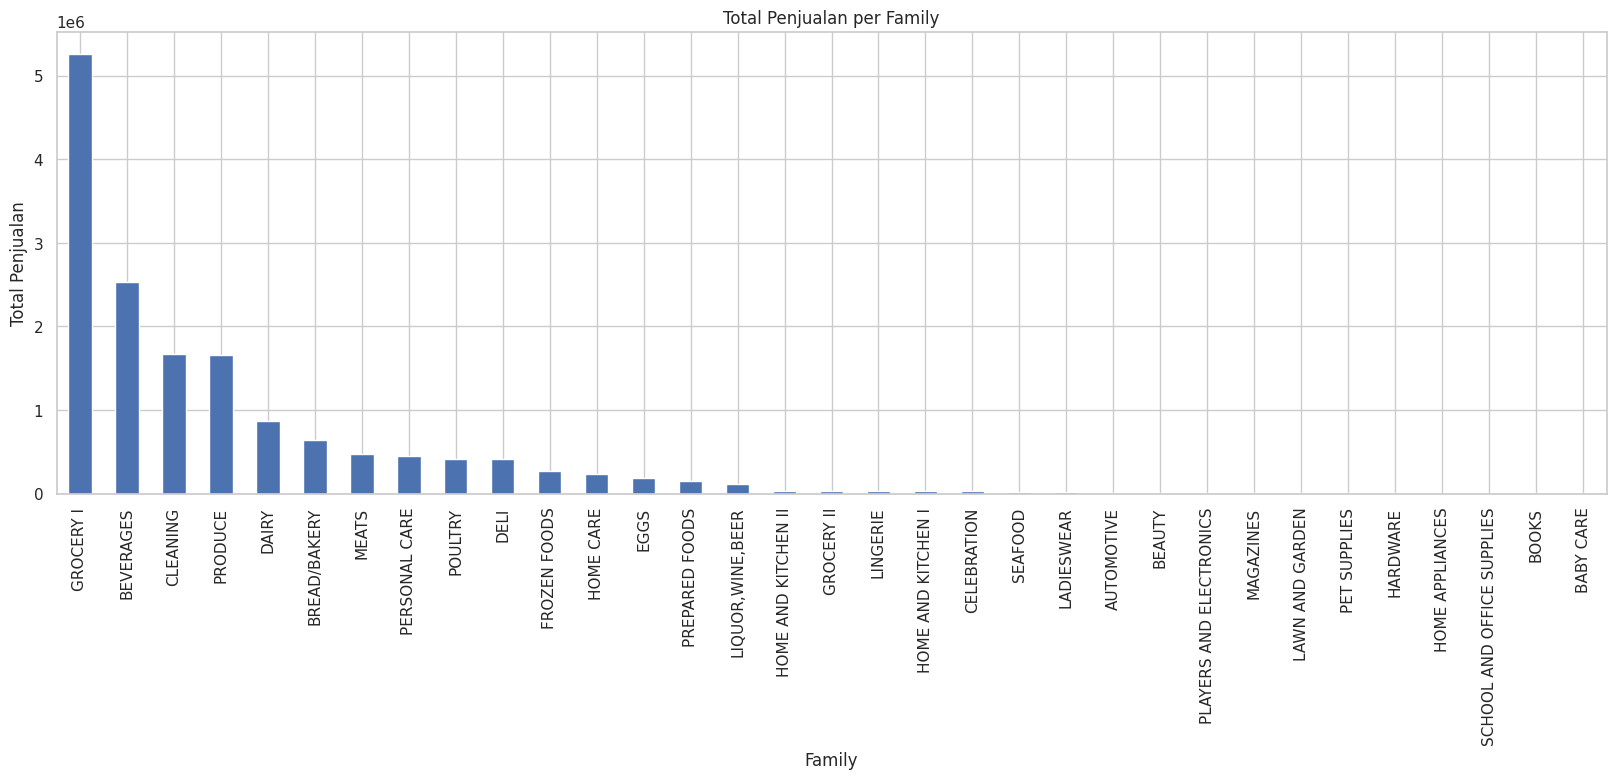

In [10]:
# plot data total penjualan berdasarkan family
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

# Gunakan fungsi groupby dan sum untuk menghitung total penjualan per family
df_train.groupby('family')['sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Penjualan per Family')
plt.xlabel('Family')
plt.ylabel('Total Penjualan')
plt.show()

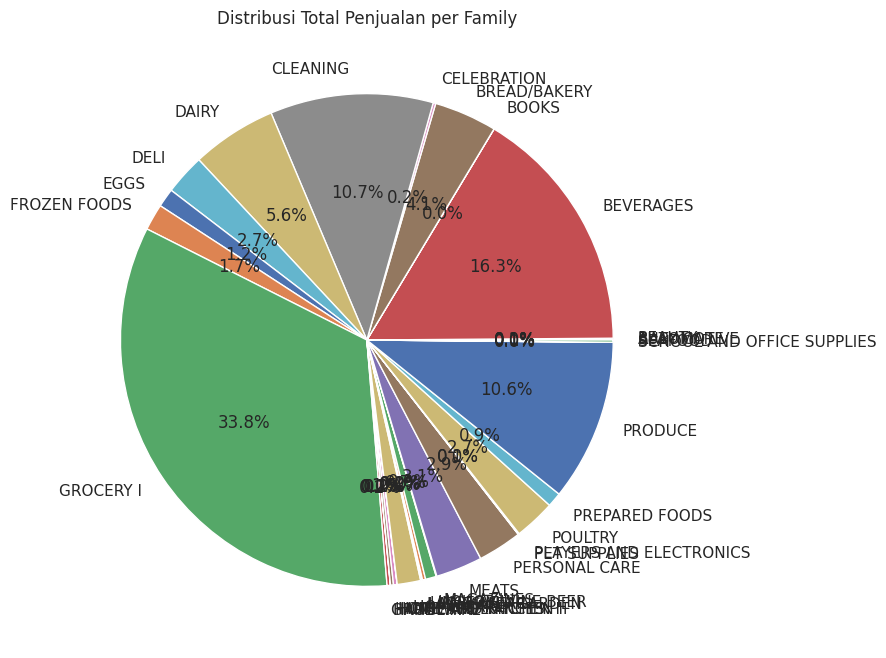

In [11]:
# Menghitung total penjualan per family
total_sales_per_family = df_train.groupby('family')['sales'].sum()

# Membuat pie chart
plt.figure(figsize=(10, 8))
total_sales_per_family.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribusi Total Penjualan per Family')
plt.ylabel('')  # Menghilangkan label y-axis karena tidak diperlukan di pie chart
plt.show()

## EDA HOME AND KITCHEN II

In [14]:
# Ambil data penjualan untuk family HOME AND KITCHEN II
homekitchen = df_train['family']=='HOME AND KITCHEN II'
homekitchen = df_train[homekitchen]
homekitchen

,family,sales
date,,
2013-01-01,HOME AND KITCHEN II,0.0
2013-01-02,HOME AND KITCHEN II,0.0
2013-01-03,HOME AND KITCHEN II,0.0
2013-01-04,HOME AND KITCHEN II,0.0
2013-01-05,HOME AND KITCHEN II,0.0
...,...,...
2017-08-11,HOME AND KITCHEN II,29.0
2017-08-12,HOME AND KITCHEN II,17.0
2017-08-13,HOME AND KITCHEN II,20.0


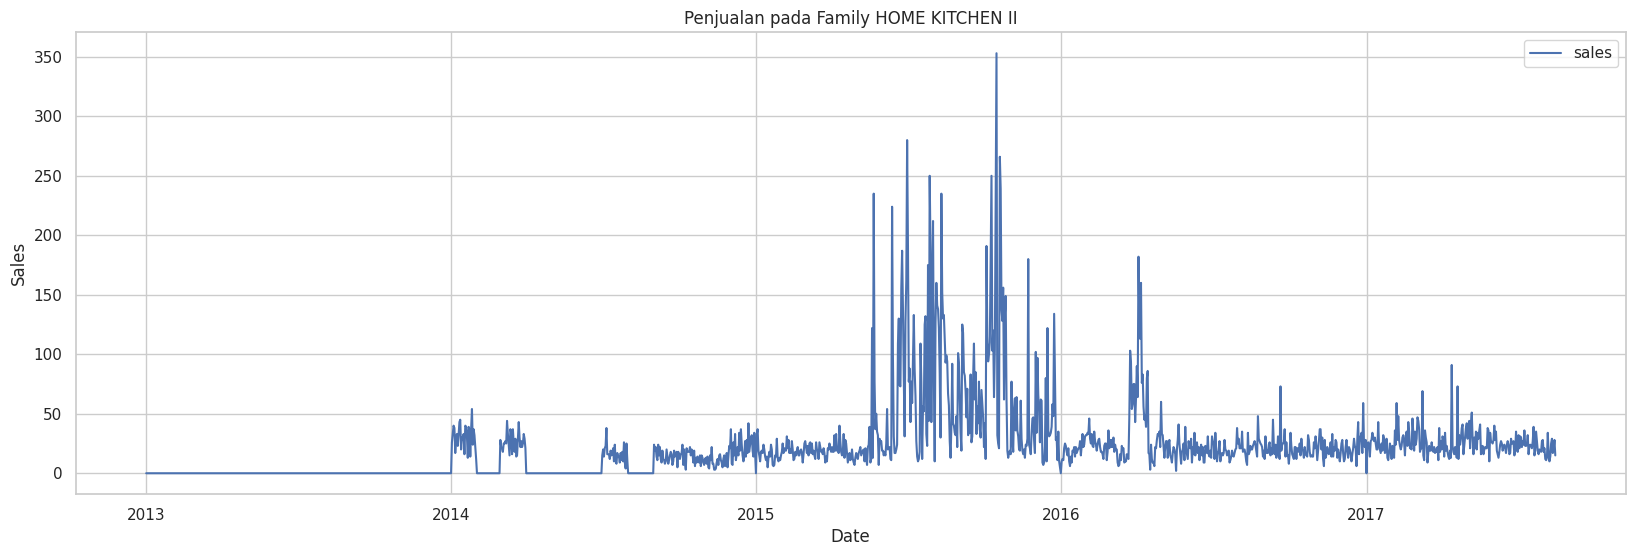

In [15]:
# Melihat penjualan pada family HOME KITCHEN II
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=homekitchen, x='date', y='sales', label='sales')
plt.title('Penjualan pada Family HOME KITCHEN II')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='date'>

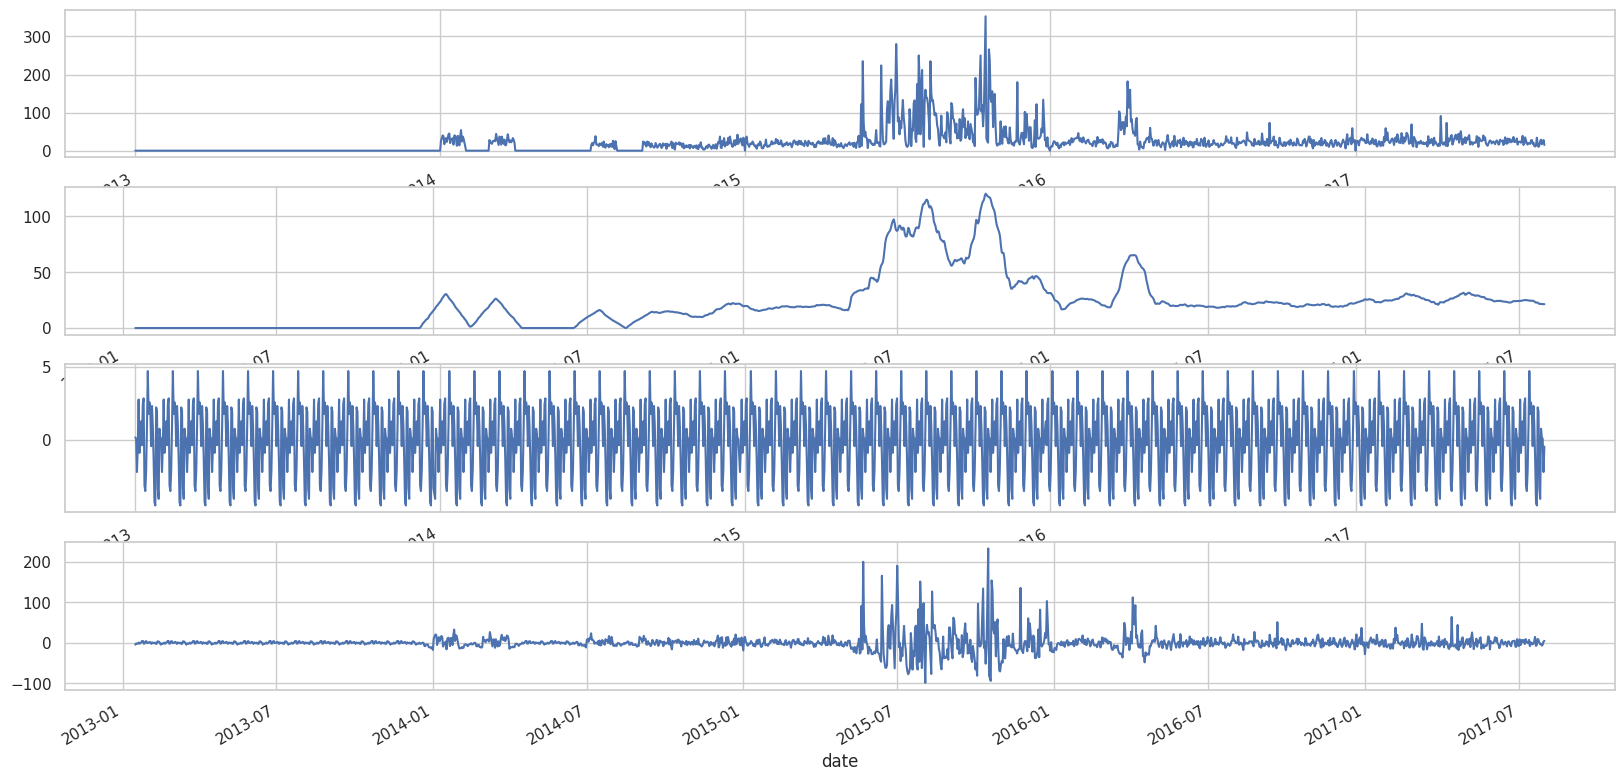

In [16]:
# Decompose data transactions
plot_decompose = seasonal_decompose(homekitchen['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

In [17]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(homekitchen['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.940819
p-value: 0.001754


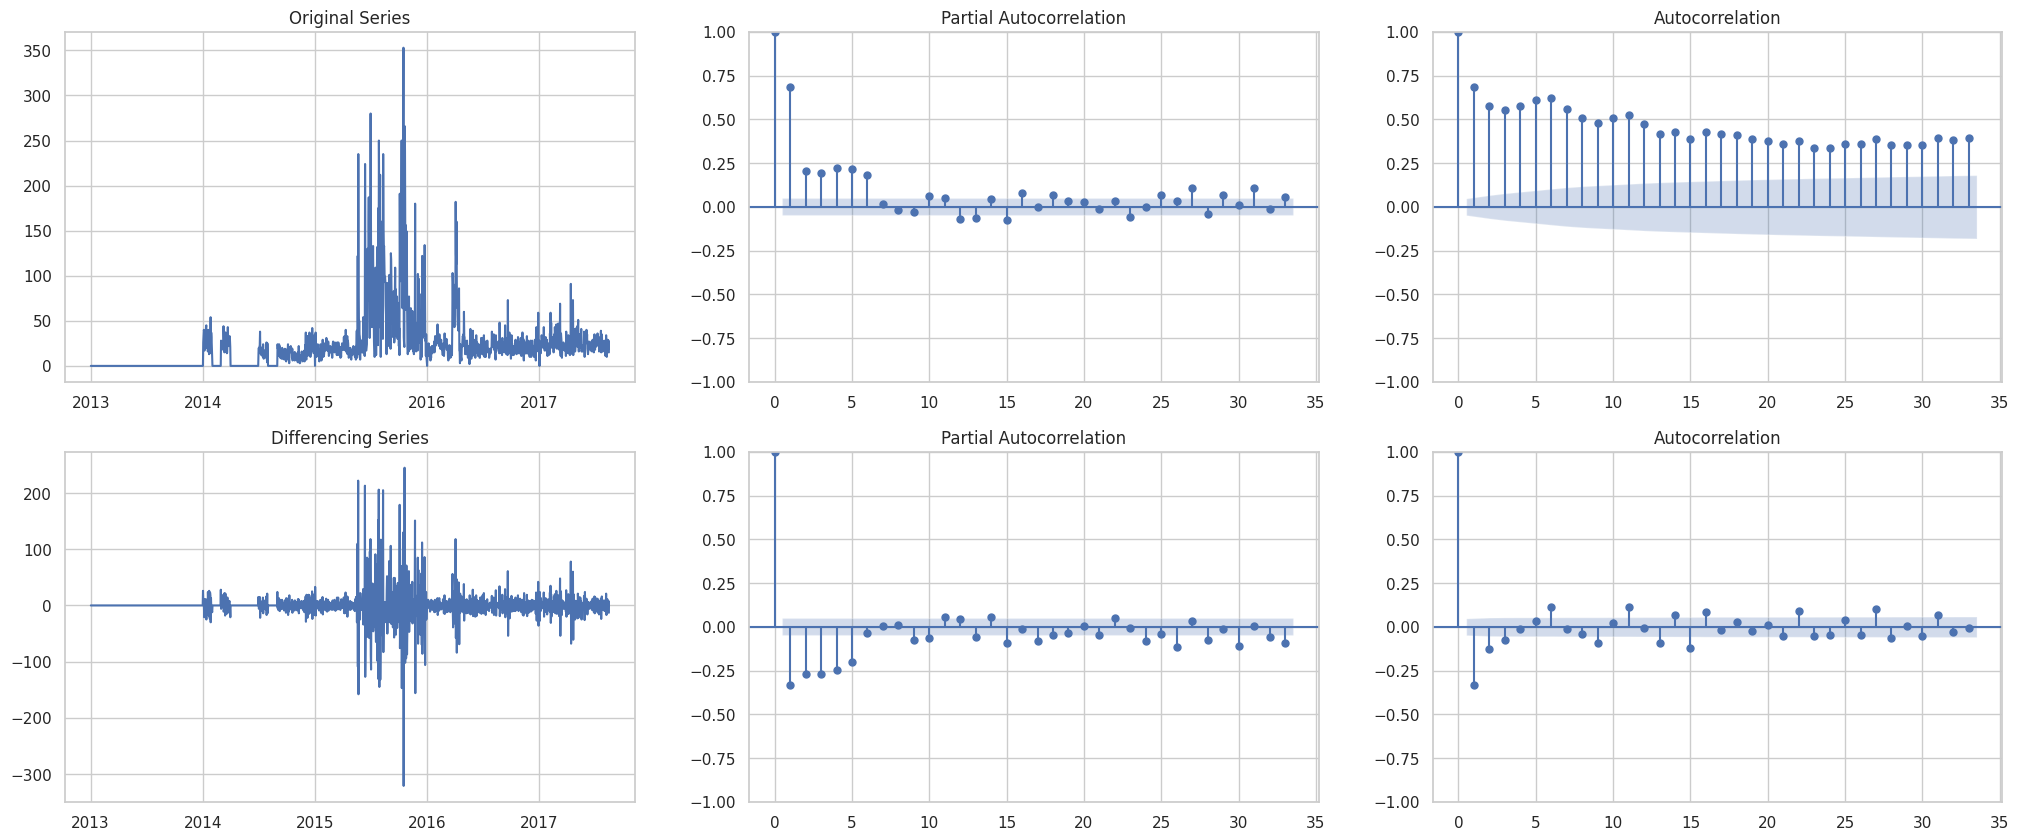

In [19]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(homekitchen['sales'])
ax[0, 1] = plot_pacf(homekitchen['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(homekitchen['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(homekitchen['sales'].diff().dropna())
ax[1, 1] = plot_pacf(homekitchen['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(homekitchen['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

## Feature Engineering

In [20]:
# Membagi fitur tanggal menjadi tahun, bulan, dan hari
homekitchen = homekitchen.copy()
homekitchen.loc[:, 'year'] = homekitchen.index.year
homekitchen.loc[:, 'month'] = homekitchen.index.month
homekitchen.loc[:, 'day'] = homekitchen.index.day
homekitchen.loc[:, 'dayofweek'] = homekitchen.index.dayofweek
homekitchen

,family,sales,year,month,day,dayofweek
date,,,,,,
2013-01-01,HOME AND KITCHEN II,0.0,2013,1,1,1
2013-01-02,HOME AND KITCHEN II,0.0,2013,1,2,2
2013-01-03,HOME AND KITCHEN II,0.0,2013,1,3,3
2013-01-04,HOME AND KITCHEN II,0.0,2013,1,4,4
2013-01-05,HOME AND KITCHEN II,0.0,2013,1,5,5
...,...,...,...,...,...,...
2017-08-11,HOME AND KITCHEN II,29.0,2017,8,11,4
2017-08-12,HOME AND KITCHEN II,17.0,2017,8,12,5
2017-08-13,HOME AND KITCHEN II,20.0,2017,8,13,6


In [21]:
# Menambahkan rolling window mean pada sales sepanjang 7 hari
homekitchen['sales_mean_7'] = homekitchen['sales'].rolling(window=7).mean()
# Menambahkan rolling window mean pada sales sepanjang 30 hari
homekitchen['sales_mean_30'] = homekitchen['sales'].rolling(window=30).mean()
homekitchen

,family,sales,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,
2013-01-01,HOME AND KITCHEN II,0.0,2013,1,1,1,NaN,NaN
2013-01-02,HOME AND KITCHEN II,0.0,2013,1,2,2,NaN,NaN
2013-01-03,HOME AND KITCHEN II,0.0,2013,1,3,3,NaN,NaN
2013-01-04,HOME AND KITCHEN II,0.0,2013,1,4,4,NaN,NaN
2013-01-05,HOME AND KITCHEN II,0.0,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...
2017-08-11,HOME AND KITCHEN II,29.0,2017,8,11,4,20.285714,21.733333
2017-08-12,HOME AND KITCHEN II,17.0,2017,8,12,5,20.857143,21.233333
2017-08-13,HOME AND KITCHEN II,20.0,2017,8,13,6,18.857143,21.366667


In [22]:
# Split data menjadi data training dan data testing
train = homekitchen[:-30]
test = homekitchen[-30:]
print('Train shape Home Kitchen II:', train.shape)
print('Test shape Home Kitchen II:', test.shape)

Train shape Home Kitchen II: (1654, 8)
Test shape Home Kitchen II: (30, 8)


# Model

## ARIMA

In [24]:
#ARIMA
model_arima = ARIMA(train['sales'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1654
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7504.248
Date:                Sat, 16 Mar 2024   AIC                          15016.497
Time:                        05:43:24   BIC                          15038.141
Sample:                             0   HQIC                         15024.520
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1195     10.497      2.107      0.035       1.545      42.694
ar.L1          0.9716      0.004    231.677      0.000       0.963       0.980
ma.L1         -0.7165      0.008    -88.064      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


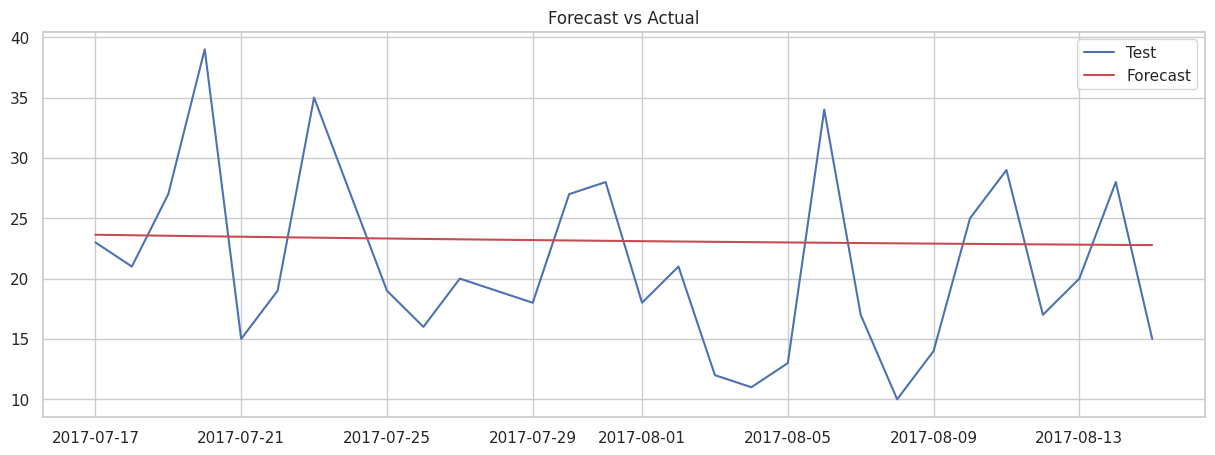

In [26]:
# Prediction
forecast = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [27]:
# check forecast row
forecastARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastARIMA

,test,forecast
date,,
2017-07-17,23.0,23.635921
2017-07-18,21.0,23.592805
2017-07-19,27.0,23.550916
2017-07-20,39.0,23.510217
2017-07-21,15.0,23.470676
2017-07-22,19.0,23.432258
2017-07-23,35.0,23.394933
2017-07-24,27.0,23.358670
2017-07-25,19.0,23.323437


## SARIMA

In [28]:
# Seasonal ARIMA (SARIMA)
model_sarima = ARIMA(train['sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -7504.134
Date:                         Sat, 16 Mar 2024   AIC                          15020.268
Time:                                 05:58:36   BIC                          15052.734
Sample:                                      0   HQIC                         15032.303
                                        - 1654                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1029     10.798      2.047      0.041       0.939      43.267
ar.L1          0.9733      0.004    225.260      0.000     

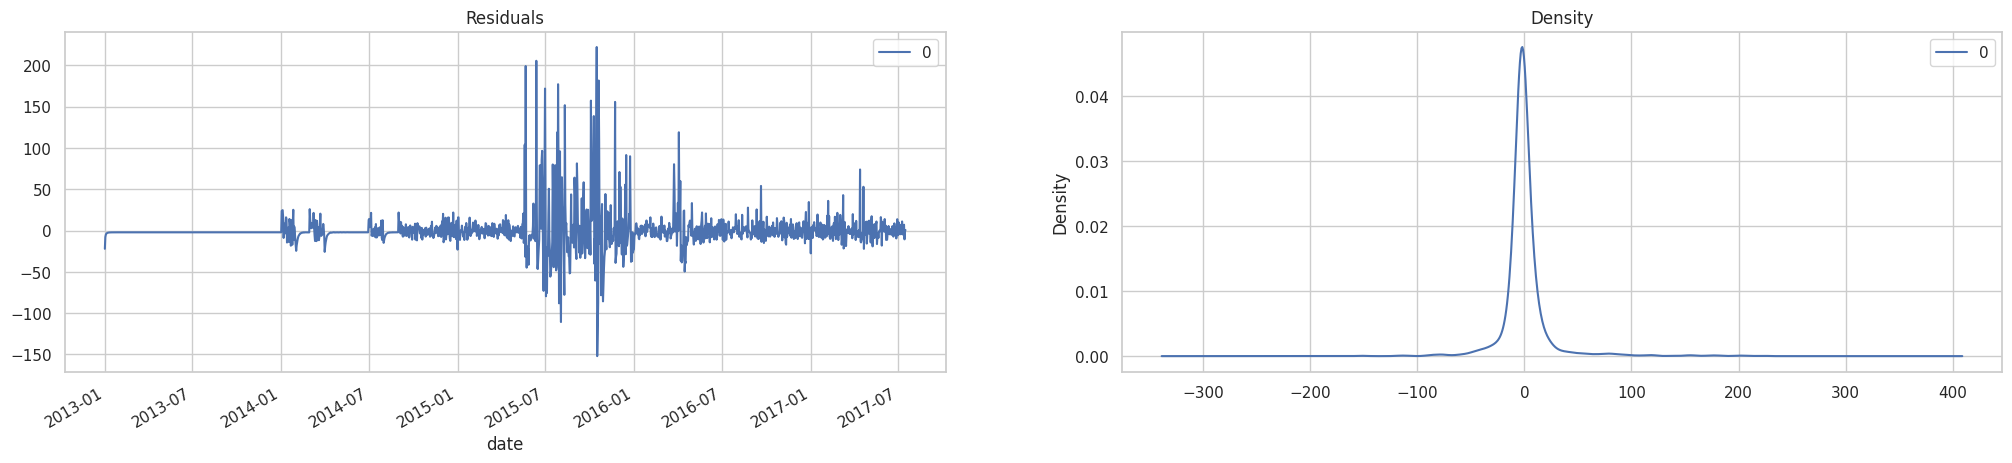

In [29]:
# Plot residual errors
residuals = pd.DataFrame(model_sarima_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


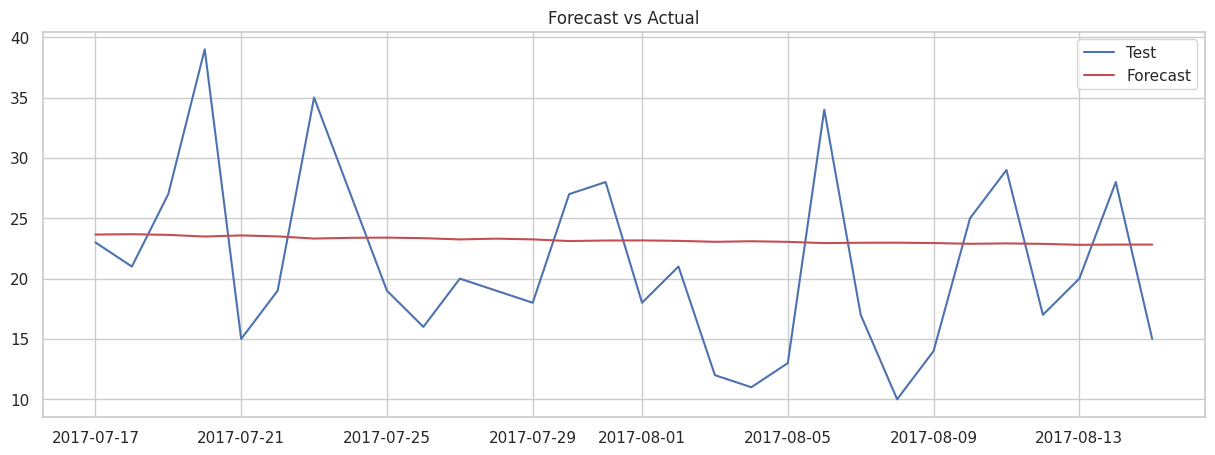

In [30]:
# Prediction
forecast = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [31]:
# check forecast row
forecastSARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMA

,test,forecast
date,,
2017-07-17,23.0,23.652702
2017-07-18,21.0,23.679790
2017-07-19,27.0,23.622625
2017-07-20,39.0,23.487069
2017-07-21,15.0,23.578654
2017-07-22,19.0,23.499729
2017-07-23,35.0,23.318289
2017-07-24,27.0,23.380344
2017-07-25,19.0,23.396920


# Uji Metriks

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
model = [forecastARIMA, forecastSARIMA]
model_name = ['ARIMA', 'SARIMA']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

,MAE,MSE,R2
ARIMA,6.408300,54.527376,-0.053081
SARIMA,6.440243,55.016426,-0.062526
